# Case studies of Waroona and Sir Ivan fires


## Objective 1, 1a: 
Access and post-process ACCESS model output.
Develop cross sections, other visualisations, and animations of multiple fields from the model output.


### Access model output (converted to netcdf)
 - Harvey Ye configures and runs ACCESS-Fire, which outputs GRIB and stash files 
 - Outputs are split into: 
   - single level [t, lat, lon] 
   - rho level [t, lev, lat, lon]
   - and theta level [t, lev, lat, lon]
 - 24 of each output file are produced, one for each hour, with 10 minute output timesteps
 - some model output variables are staggered in one dimension
 - I converted all these to netcdf using the Chun Su's iris conversion script

Horizontal winds are on staggered grids, these are linearly interpolated onto matching grids where they appear.

### Fire model output (netcdf)
 - temporal resolution of 1 minute
 - each variable has 1 file per 24h (1440 length time dim)
 - fire_front is negative where fire has burnt, and positive where it has not burnt

#### other versions
 - Recently we have wanted to look at older runs
 - These are dispersed through NCI, and linked to within my project in an ordered fashion

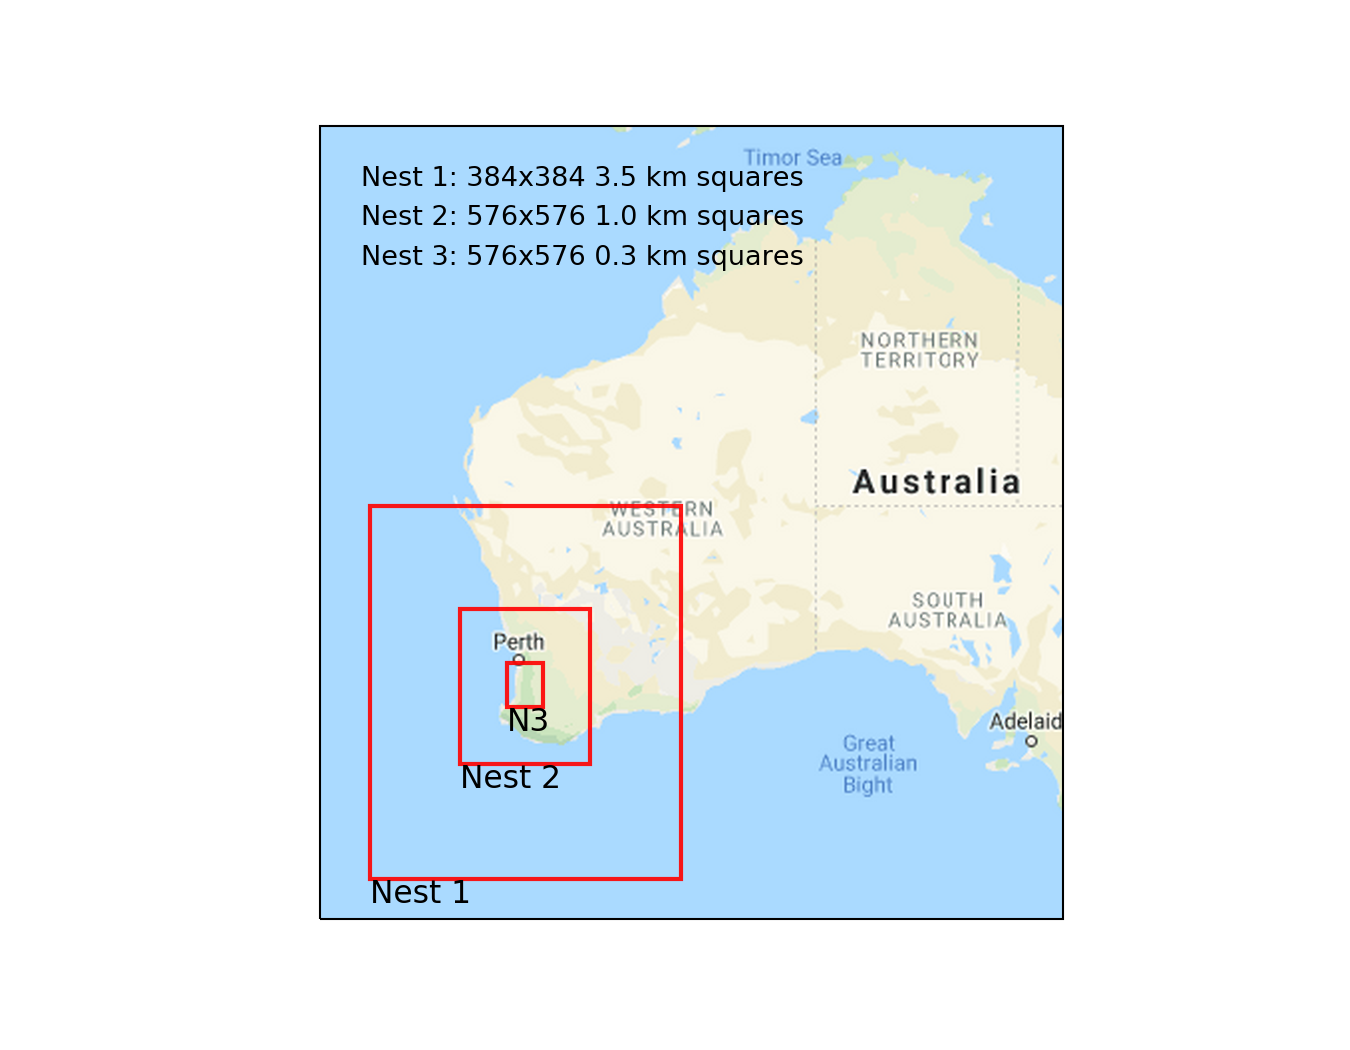

In [1]:
###
###  Imports and globally useful stuff here
###
# Show plots in the browser
%matplotlib inline
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
#from matplotlib.colors import Normalize
import numpy as np
from datetime import datetime,timedelta

# Display an image from file:
from IPython.display import Image
#Image(filename='test.png') 
import matplotlib.image as mpimg

import iris
import iris.quickplot as qplt
from utilities import plotting, utils, fio

um_dtimes = [datetime(2016,1,5,15) + timedelta(hours=x) for x in np.arange(24,dtype=float)]

# Lets show the model coverage here
Image(filename='figures/waroona_run1/maps/nested_grid.png')

In [2]:
##
## READ WAROONA MODEL DATA INTO IRIS CUBES:
##
extent = plotting._extents_['waroona']
slv, ro1, th1, th2 = fio.read_waroona(um_dtimes[0], extent=extent, add_winds=True, add_theta=True)

##
## READ FIREFRONT MODEL OUTPUT:
##
f_dtimes = [um_dtimes[-1] + timedelta(minutes=x) for x in np.arange(10,61,10,dtype=float)]
ff = fio.read_fire(dtimes=f_dtimes,extent=extent, firefront=True)

for cube in [slv,ro1,th1,th2]:
    print('============')
    print(cube)

print('============')
print(ff)

INFO: Reading(iris)  data/waroona_run1/umnsaa_2016010515_slv.nc
INFO: Reading(iris)  data/waroona_run1/umnsaa_2016010515_slv.nc
INFO: Reading(iris)  data/waroona_run1/umnsaa_2016010515_mdl_ro1.nc
INFO: Reading(iris)  data/waroona_run1/umnsaa_2016010515_mdl_th1.nc
INFO: Reading(iris)  data/waroona_run1/umnsaa_2016010515_mdl_th2.nc
INFO: Reading(iris)  data/waroona_run1/fire/firefront.CSIRO_24h.20160105T1500Z.nc
0: specific_humidity / (1)             (time: 6; latitude: 125; longitude: 152)
1: surface_air_pressure / (Pa)         (time: 6; latitude: 125; longitude: 152)
2: air_pressure_at_sea_level / (Pa)    (time: 6; latitude: 125; longitude: 152)
3: surface_temperature / (K)           (time: 6; latitude: 125; longitude: 152)
4: topog / (m)                         (latitude: 125; longitude: 152)
0: air_pressure / (Pa)                 (time: 6; model_level_number: 140; latitude: 125; longitude: 152)
1: x_wind / (m s-1)                    (time: 6; model_level_number: 140; latitude: 125; l

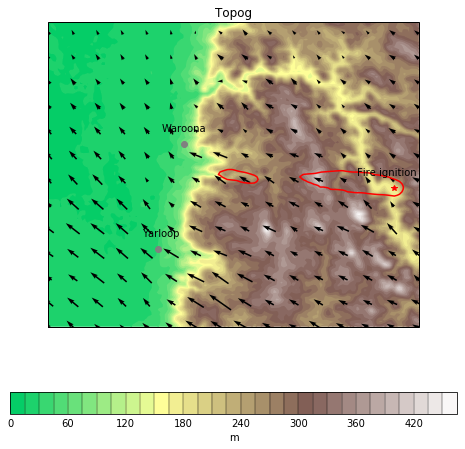

In [3]:
# check the topography
topog=slv.extract('topog')[0]
plt.figure(figsize=[8,8])
qplt.contourf(topog, 40, cmap='terrain',vmin=-150) # set vmin so that blue range is around 0 or below

# show wind direction quiver plot
lat = topog.coord('latitude').points
lon = topog.coord('longitude').points
u,v = ro1[4][0,0].data, ro1[5][0,0].data
skip=slice(None,None,10)
plt.quiver(lon[skip],lat[skip],u[skip,skip],v[skip,skip], pivot='middle',scale=60)

# show fire front 
plt.contour(lon,lat,np.transpose(ff[0][0].data), np.array([0]),colors='r')
# this one only shows fire front after 2016010604ish when the fire starts

# show towns...
plotting.map_add_locations_extent('waroona')

plt.show()

# First we examine model output

## Trying to determine what feedback can be seen in the model output
 1. Winds both horizontally and vertically can be examined through python visualisations
 2. cloud creation should be shown, due to the fire driven updrafts
   - Some updrafts are seen but they are relatively localised
 3. horizontal slices of vertical wind speed at different model levels may help pinpoint pyrogenic cloud formation

 
##### Often an examination is performed along a transect
 * Transects are formed using RectBivariateSpline interpolation along the line


## Transects

#### Where is the fire, where are we looking?
Several horizontal transects are used to examine vertical cross sections. These are shown here along with the fire front at the end of day 1.

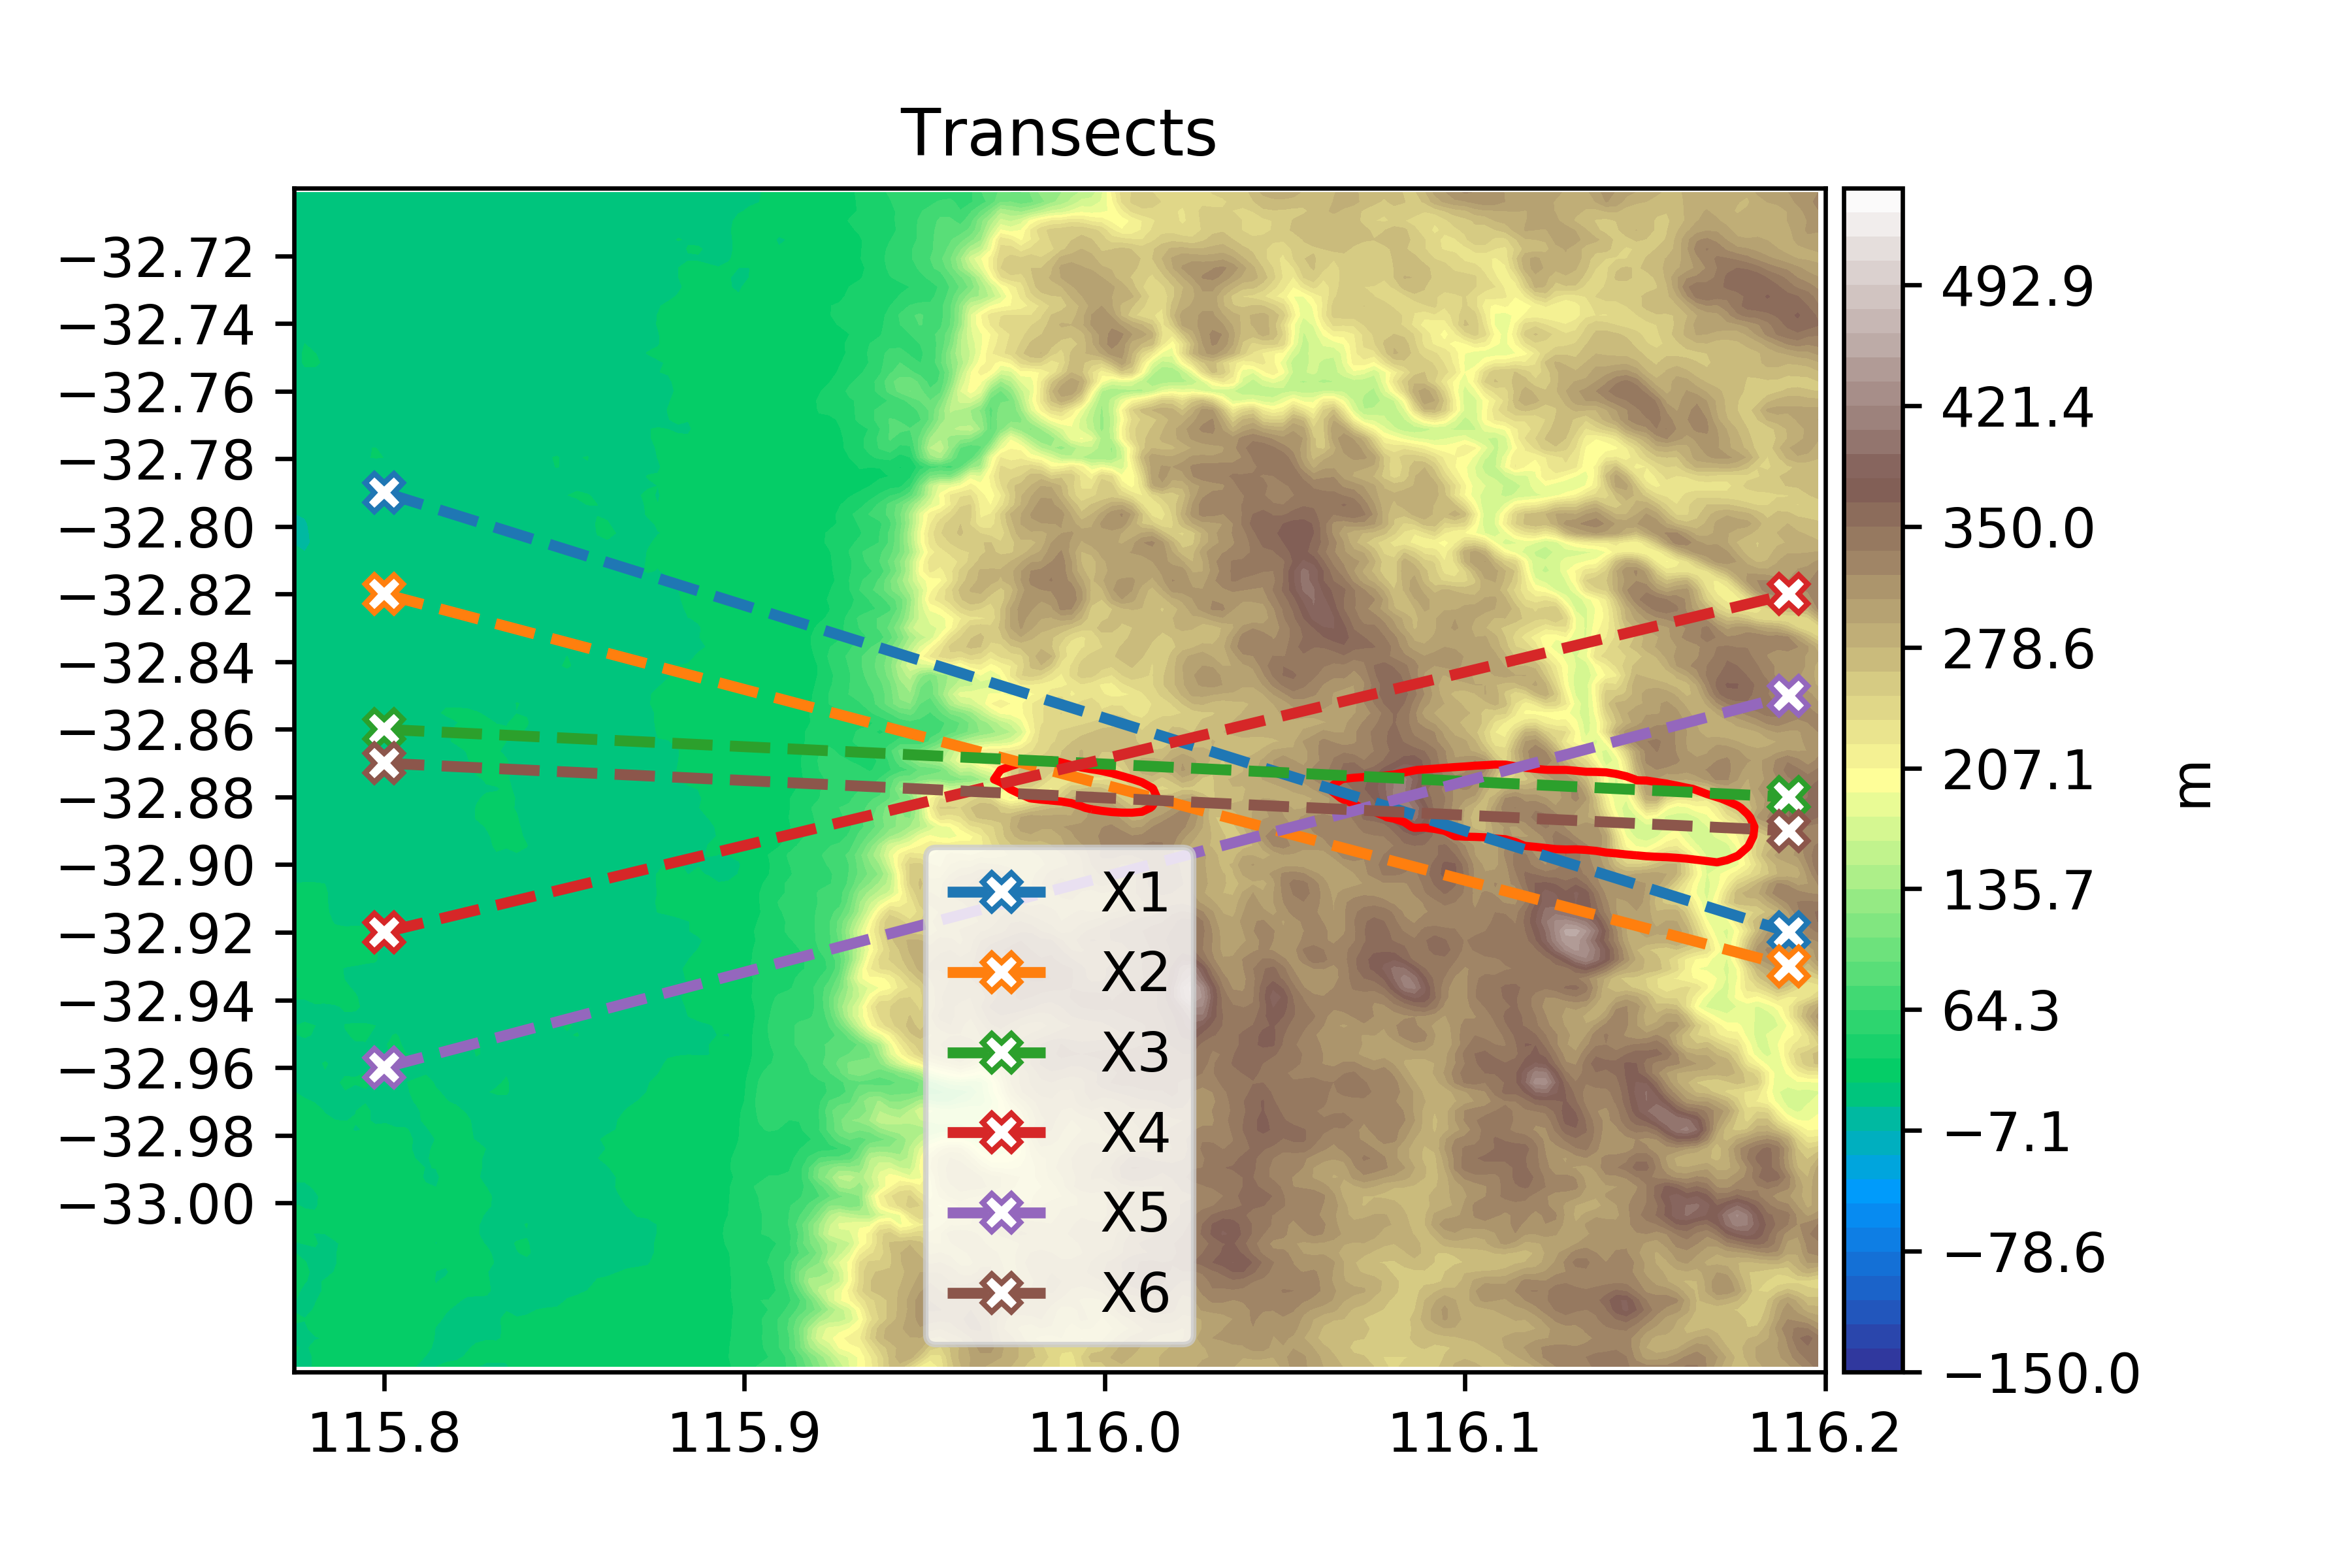

In [4]:
# Show transects

transects = plotting._transects_
extents = plotting._extents_

extentname='waroona'
plotting.map_topography(extents[extentname],topog.data,lat,lon)
plt.title("Transects")

plt.contour(lon,lat, np.transpose(ff[0][0].data),np.array([0]),colors='red')

for transect in range(6):
    start,end = transects["%s%d"%(extentname,transect+1)]
    plt.plot([start[1],end[1]],[start[0],end[0], ], '--', 
             linewidth=2, label='X%d'%(transect+1),
             marker='X', markersize=7,markerfacecolor='white')

plt.legend()
plt.yticks(np.arange(-33,-32.7,.02))
plt.xticks(np.arange(115.8,116.21,.1))
pname="figures/waroona/transects.png"
plt.savefig(pname,dpi=600)
plt.close()
Image(filename=pname)


## Modelled winds

Winds can be described using three vectors:
 1. x_winds: horizontal west-east wind speeds
 2. y_winds: horizontal south-north wind speeds
 3. upward : vertical wind speeds

These are summarised along each transect in the following plot.

### Outline of weather at fire site

#### 211 topography, sites of interest, surface wind, and transect line
First panel shows topography, wind speed, wind direction, and the current fire front

#### 223 vertical motion along transect
This panel shows vertical motion, and also outlines clouds using the 0.01g/kg threshold of cloud water + cloud ice

#### 224 horizontal wind speed along transect
Horzontal wind speed for each model level are calculated using the hypotenuse of x_winds and y_winds, and shown along the transect.

In [19]:
### The plot is written in wind_outline.py
## script can be run in NCI after running environment_setup.py

# show example image:
#Image(filename='figures/waroona/winds_outline_X5/fig_201601051510.png')

## Making videos from figures
#
##### ffmpeg video creation script is in the figures folder
#
#accessfires$cat figures/make_video.sh
##!/bin/bash
#
##Run this from the subfolder with all your images in it
#module load ffmpeg
#
#ffmpeg -pattern_type glob -framerate 2 -i '*.png' -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p video.mp4

from IPython.display import Video

Video("figures/waroona_run1/animations/winds_x3.mp4")

## Also looking for an idea of cloud formation driven by the fire

 - Vertical motion gives a rough idea of updrafts and downdrafts within the boundary layer
 - frozen and liquid water content is output and used to determine cloud location
 - cloud pyrogenesis sensitive to model inputs and parameters

## Turns out clouds are hard to pinpoint

#### Exploring horizontal slices at various model levels could help
 1. The vertical wind component can be roughly eyeballed by taking slices over various vertical levels
 2. cloud structure overplotted using water and ice content



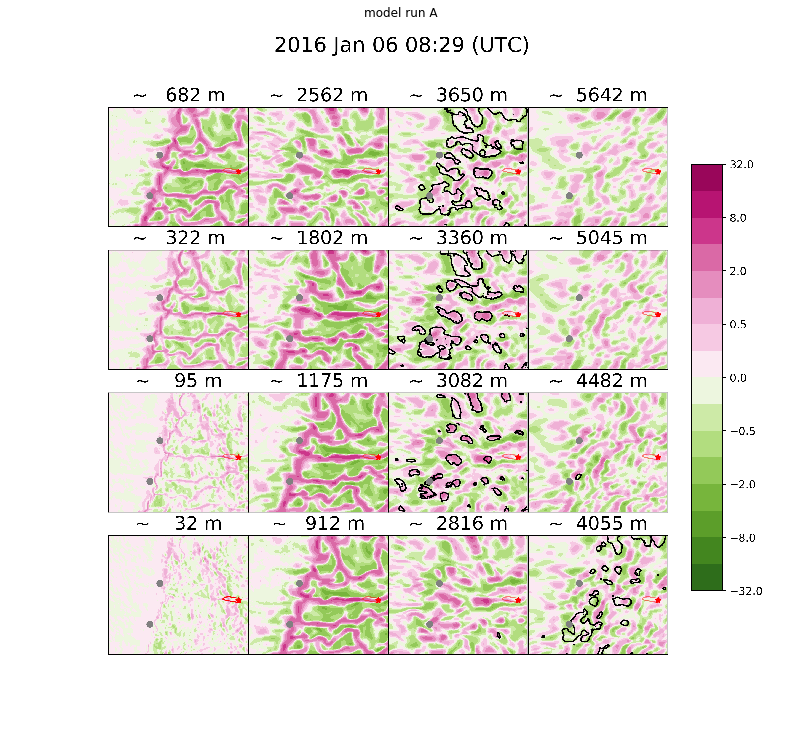

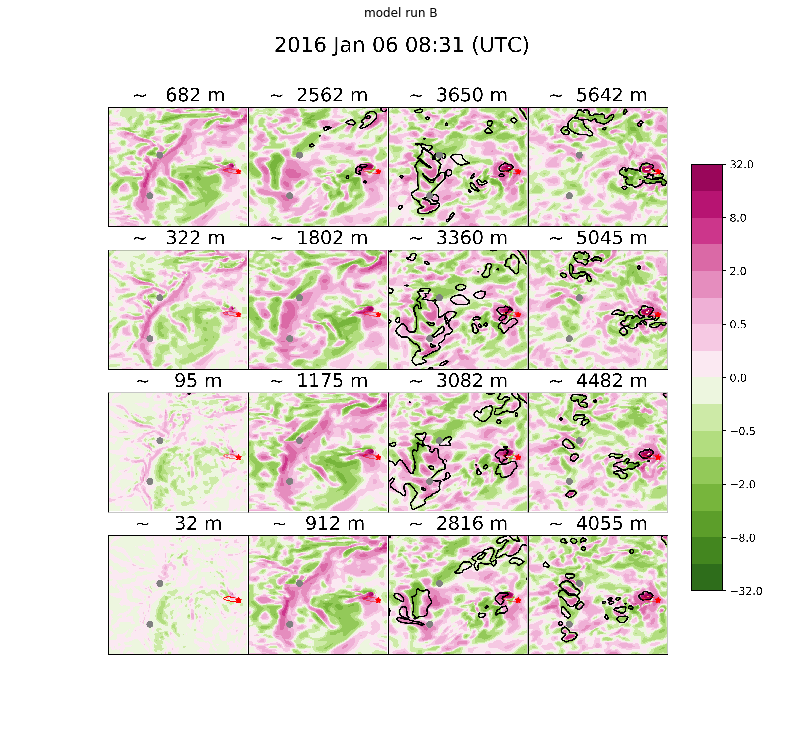

In [23]:
## Vertical motion in horizontal slices created in script vertical_motion_slices

# Read images
# figures/waroona/vert_motion_slices
img1 = mpimg.imread('figures/waroona_run1/vert_motion_slices/fig_201601060829.png')
img2 = mpimg.imread('figures/waroona_old/vert_motion_slices/fig_201601060831.png')

# show images
plt.figure(figsize=[14,14])
plt.imshow(img1)
plt.title('model run A')
plt.xticks([],[])
plt.yticks([],[])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()


plt.figure(figsize=[14,14])
plt.imshow(img2)
plt.title('model run B')
plt.xticks([],[])
plt.yticks([],[])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

## Pyrocumulous cloud

#### One model version shows pyrocb

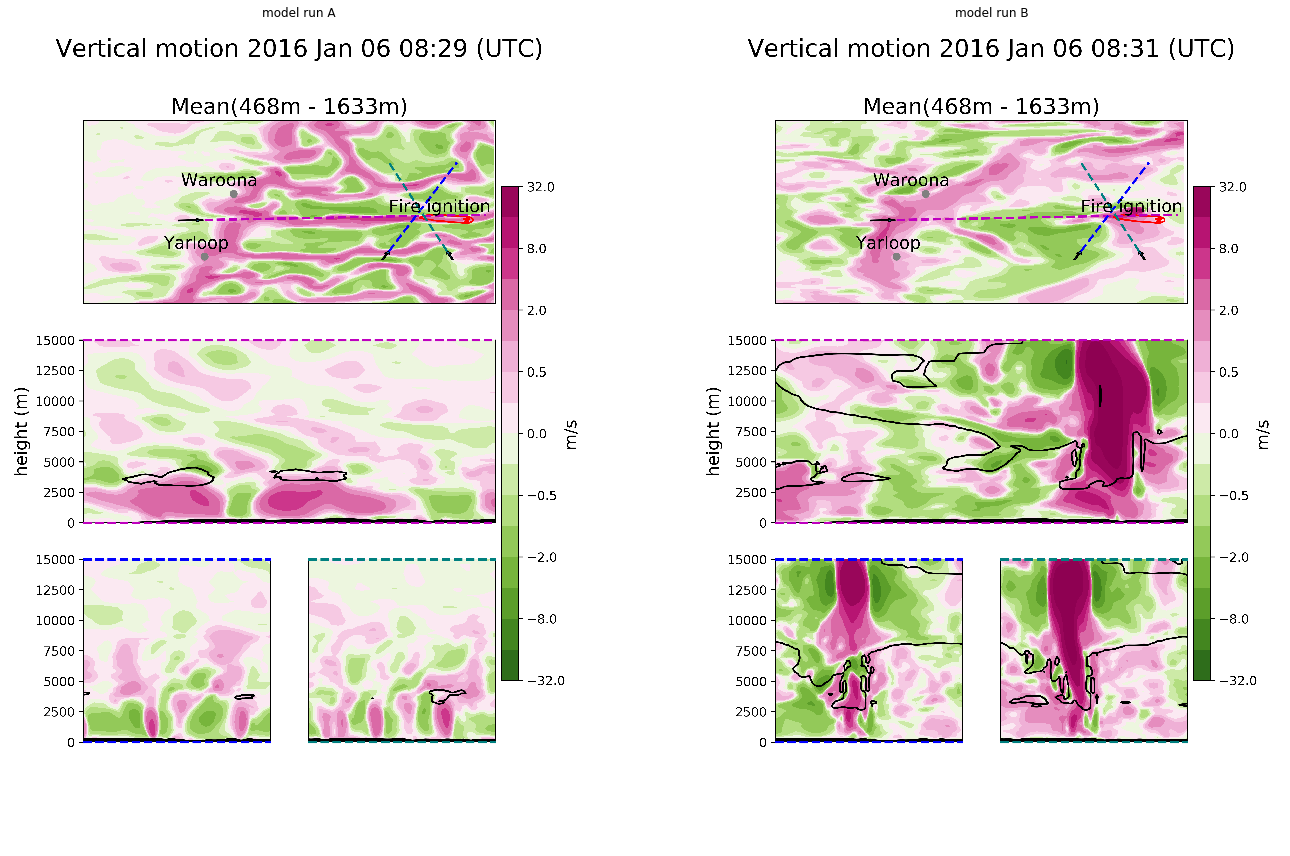

In [17]:
##plots from script pyrocb.py

# Read images
# figures/waroona/vert_motion_slices
img1 = mpimg.imread('figures/waroona/pyrocb/fig_201601060829.png')
img2 = mpimg.imread('figures/waroona/pyrocb_old/fig_201601060831.png')
# show images
plt.figure(figsize=[20,12])
ax1 = plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('model run A')
plt.xticks([],[])
plt.yticks([],[])

ax2=plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('model run B')
plt.xticks([],[])
plt.yticks([],[])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

## More to the story

This looks a lot like pyrogenic cumulonimbus.

##### Was this due to extreme fire intensity? Or were the conditions just right? Maybe both?

We can estimate how conducive to pyrogenic clouds the atmosphere is using skew-t log-p (F160) plots.

 1. After reinventing 80% of the wheel, the MetPy package was discovered and used
 2. Using calculations based on the meteorological profiles, the required fire intensity integral (Gigawatts) required to generate a pyrocb can be estimated.
 

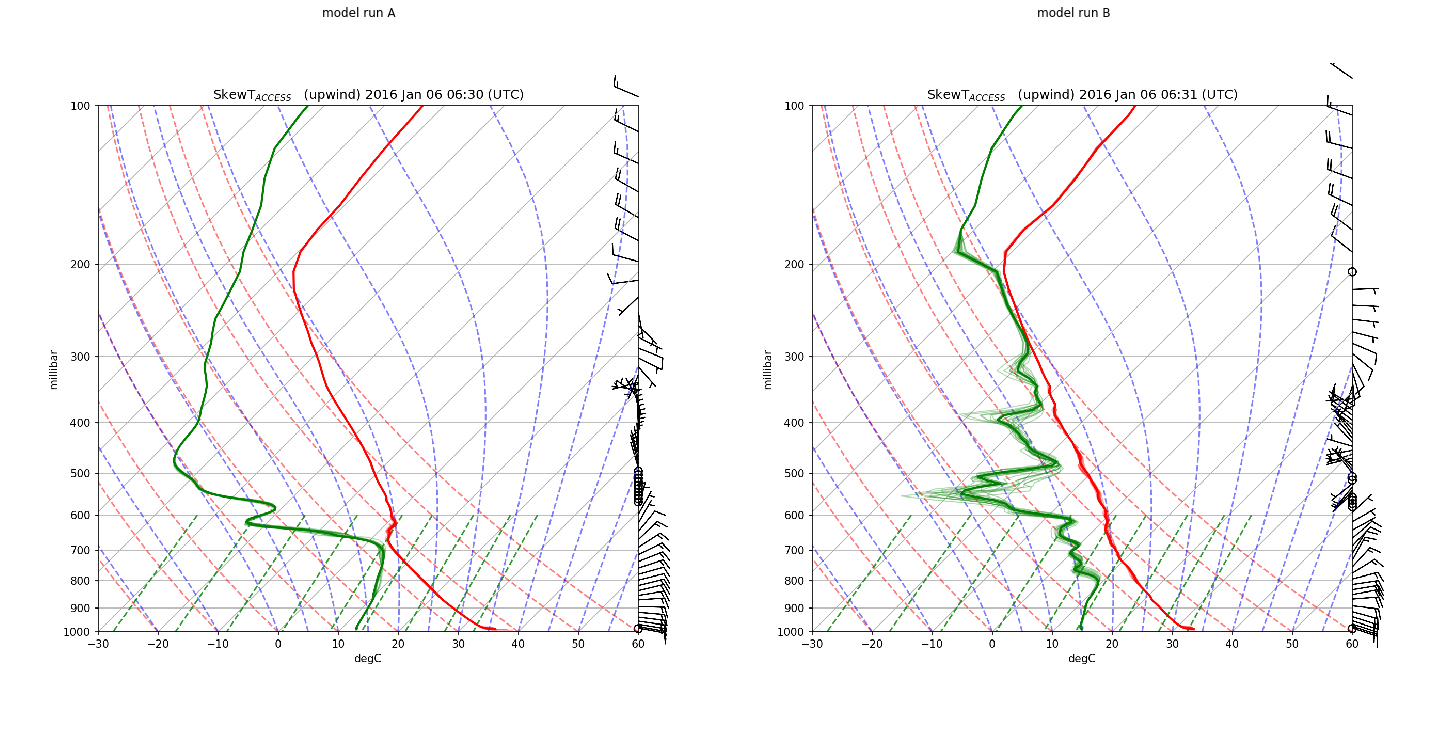

In [3]:
##plots from script f160.py

# Read images
# figures/waroona/vert_motion_slices
img1 = mpimg.imread('figures/waroona_run1/f160/upwind/fig_201601060630.png')
img2 = mpimg.imread('figures/waroona_old/f160/upwind/fig_201601060631.png')
# show images
plt.figure(figsize=[20,12])
ax1 = plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('model run A')
plt.xticks([],[])
plt.yticks([],[])

ax2=plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('model run B')
plt.xticks([],[])
plt.yticks([],[])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

## Future directions

### Analysis/exploration of current and future model runs
 - outlines of fire spread/strength
 - fire-based cloud or storm generation
 - model weather conditions

### Analysis of measurements
 - AWS measurement time series and comparisons to model output
 - Linescan swathes geolocated and analysed

### Pyrocumulous forecast power
 - are the recorded pyrogenic clouds seen or expected based on model meteorology?
 - is the model showing pyrocb when the forecast is favourable?
 
### Ember storm analysis
 - what are the modelled conditions like near where the waroona ember storm occured?
 - Do they suggest an emberstorm was likely?
 - What are the particle trajectories in the area like based on modelled winds?
 
